In [63]:
# -*- coding: utf-8 -*-
import numpy as np  
import matplotlib.pyplot as plt  
from scipy.io import loadmat  
from collections import Counter
from matplotlib import rcParams  

# 设置字体为某种字体，例如“SimHei”（黑体），确保电脑上安装了该字体  
rcParams['font.family'] = 'SimHei'  
rcParams['axes.unicode_minus'] = False  # 使负号显示正常  


# 1. 读取数据并进行FFT处理

121991


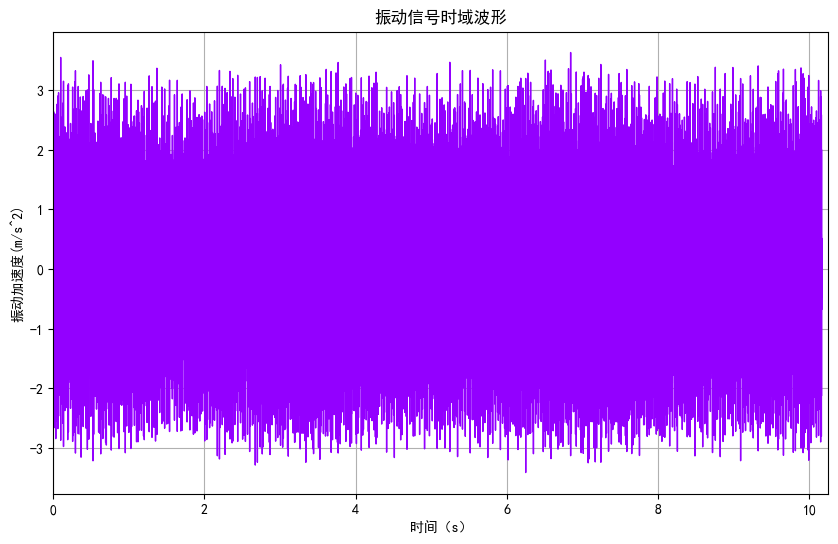

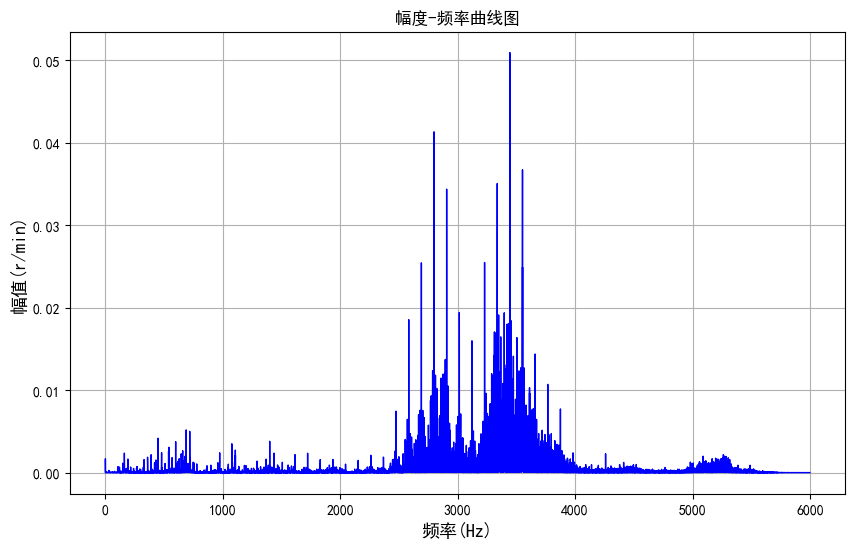

In [65]:

# 一、读入数据并进行FFT处理  
data = loadmat('130.mat')  # Load the .mat file  
X097_DE_time = data['X130_DE_time'].flatten()  # Adjust based on your data structure  
fs = 12000  # 采样频率  
t = np.arange(0, len(X097_DE_time) / fs, 1/fs)  # Generate time vector  
print(len(X097_DE_time))
# Plot original signal  
plt.figure(figsize=(10, 6))  
plt.plot(t, X097_DE_time, color=[147/255, 0/255, 255/255], linewidth=1)  
plt.grid(True)  
plt.xlim([0, 10.25])  
plt.xlabel('时间（s）')  
plt.ylabel('振动加速度(m/s^2)')  
plt.title('振动信号时域波形')  
plt.show()  

# FFT processing  
N = len(t)  # 采样点数  
signal = X097_DE_time  
x = signal - np.mean(signal)  # 预处理，去除直流分量  
x = x / np.max(np.abs(x))  # 归一化  
y = np.fft.fft(x, N)  # 做FFT变换  
y1 = np.abs(y)  # 取模  
ayy = y1 / (N / 2)  # 换算成实际的幅度  
ayy[0] = ayy[0] / 2  # Adjust the first element  
f = np.arange(N) * fs / N  # 换算成实际的频率值  

# Plot amplitude-frequency curve  
plt.figure(figsize=(10, 6))  
plt.plot(f[:N // 2], ayy[:N // 2], color=[0, 0, 255/255], linewidth=1)  
plt.grid(True)  
plt.xlabel('频率(Hz)', fontsize=13)  
plt.ylabel('幅值(r/min)', fontsize=13)  
plt.title('幅度-频率曲线图')  
plt.show()  

# 2. 包络分析

In [5]:
import numpy as np  
import matplotlib.pyplot as plt  
from scipy.fft import fft  
from scipy.signal import hilbert  
from scipy.io import loadmat  

In [ ]:

file_names = {'097':0 ,'105':1, '118':2, '130':3, '169':4, '185':5, '197':6, '209':7, '222':8, '234':9,'098':0, '099':0,'106':1,'107':1,'119':2,'120':2,'131':3,'132':3,'170':4,'171':4,'186':5,'187':5,'198':6,'199':6,'210':7,'211':7,'223':8,'224':8,'235':9,'236':9}

def data_load(file_names,filename):
    if int(filename) > 100:
        data = loadmat(f'data/12k Drive End Bearing Fault Data/{filename}.mat')  # Adjust to the correct path of your .mat file  
    elif int(filename) < 100:
        data = loadmat(f'data/Normal Baseline Data/{filename[1:]}.mat')  # Adjust to the correct path of your .mat file
    X_DE_time = data[f'X{filename}_DE_time'].flatten()  # Flattening in case it's a 2D array  
    
    # Sampling frequency  
    fs = 12000  # Sampling frequency  
    t = np.arange(len(X_DE_time)) / fs  # Time array  
    
    # Plot original signal  
    # plt.figure(1)  
    # plt.plot(t, X130_DE_time, color=[147/255, 0/255, 255/255], linewidth=1)  
    # plt.grid(True)  
    # plt.xlim([0, 10.25])  
    # plt.xlabel('时间（s）')  
    # plt.ylabel('振动加速度(m/s^2)')  
    # plt.title('振动信号时域波形')  
    # 
    # Envelope Analysis  
    analytic_signal = hilbert(X_DE_time)  # Compute Hilbert transform  
    envelope = np.abs(analytic_signal)  # Envelope from the analytic signal  
    
    # Perform FFT on the envelope  
    N = len(envelope)  # Number of samples  
    envelope_fft = fft(envelope, N)  
    envelope_magnitude = np.abs(envelope_fft) / (N / 2)  # Convert to amplitude  
    envelope_magnitude[0] = 0  # Set DC component to zero  
    
    # Frequency values (only positive frequencies)  
    f = np.arange(N) * fs / N  # Frequency values  
    positive_freq_mask = f >= 0  # Mask for positive frequencies  
    
    # Filter to positive frequencies and limit to 2000 Hz  
    freq_mask = (f <= 2000) & positive_freq_mask 
    
    # Prepare data for plotting, only considering non-negative frequencies  
    frequencies = f[freq_mask]  
    magnitudes = envelope_magnitude[freq_mask]  
    
    if frequencies[np.argmax(magnitudes)]<1 or frequencies[np.argmax(magnitudes)]>900 :
        
        freq_mask2=(frequencies > 28) & (frequencies < 900)
    else:
        freq_mask2=(frequencies > 0) & (frequencies < 2000)
    # Finding the first and second highest peaks (only within 0-2000 Hz)  
    if len(magnitudes) > 0:
        peak_values = np.max(magnitudes[freq_mask2]) 
        peak_indices = np.argmax(magnitudes[freq_mask2])  # Get indices of the top 2 peaks  
         
        peak_freqs = frequencies[freq_mask2][peak_indices]  
    
        # Find the index of the first peak  
        first_peak_index = peak_indices 
        
        # Get the frequency of the first peak  
        first_peak_freq = peak_freqs  
        print(peak_freqs)
        # Determine the starting point for finding '半频' (just below the first peak frequency)  
        start_freq = first_peak_freq.astype(int)  
    
        # Find the maximum magnitude from 0 to start_freq (inclusive)  
        left_mask = (frequencies > 0) & (frequencies < start_freq/1.5)  # Mask for the desired frequency range  
        if np.any(left_mask):  
            half_freq_value = np.max(magnitudes[left_mask])  
            half_freq_index = np.argmax(magnitudes[left_mask])  
            half_freq = frequencies[left_mask][half_freq_index]  
        else:  
            half_freq_value = None  
            half_freq = None  
            
        peak_values=np.append(peak_values,half_freq_value)
        peak_freqs=np.append(peak_freqs,half_freq)
        
        right_mask = (frequencies > start_freq*1.7) & (frequencies <= start_freq*2.5)  # Mask for the desired frequency range
        if np.any(right_mask):
            double_freq_value = np.max(magnitudes[right_mask])
            double_freq_index = np.argmax(magnitudes[right_mask])
            double_freq = frequencies[right_mask][double_freq_index]
        else:
            double_freq_value = None
            double_freq = None
        peak_values=np.append(peak_values,double_freq_value)
        peak_freqs=np.append(peak_freqs,double_freq)
        print(peak_freqs)
    else:  
        peak_values = []  
        peak_freqs = []  
        half_freq_value = None  
        half_freq = None  
        double_freq_value = None
        double_freq = None
    print(peak_values)
    # Plot Envelope Spectrum  
    plt.figure(2)  
    plt.plot(frequencies, magnitudes, color=[0/255, 0/255, 255/255], linewidth=1)  
    plt.grid(True)  
    plt.xlabel('频率(Hz)', fontsize=13)  
    plt.ylabel('幅值', fontsize=13)  
    plt.title('包络谱图 (0-2000 Hz)')  
    plt.xticks(fontsize=13)  
    plt.yticks(fontsize=13)  
    # 
    # Annotate the first and second highest peaks with black squares and text boxes  
    for i in range(len(peak_values)):  
        # Mark the peak with a black square point  
        plt.scatter(peak_freqs[i], peak_values[i], color='black', s=100, zorder=5, label='_nolegend_')  

        # Place the text box next to the peak  
        plt.text(peak_freqs[i] + 20, peak_values[i],  
                 f'X: {peak_freqs[i]:.1f} Hz\nY: {peak_values[i]:.4f}',  
                 fontsize=10,  
                 bbox=dict(facecolor='white', alpha=0.5, edgecolor='black', boxstyle='round,pad=0.3'),  
                 verticalalignment='center')  

    plt.show()
    # 
    # 构建一维数组
    list_DE = []
    label_DE= []
    
    list_DE.append([peak_values])
    
    label_DE.append(file_names[filename])
    
    return list_DE, label_DE

# 3. 特征选择可视化

29.90923923291984
[29.90923923 11.41273602 59.86767129]
[0.02225948 0.00514114 0.01261861]


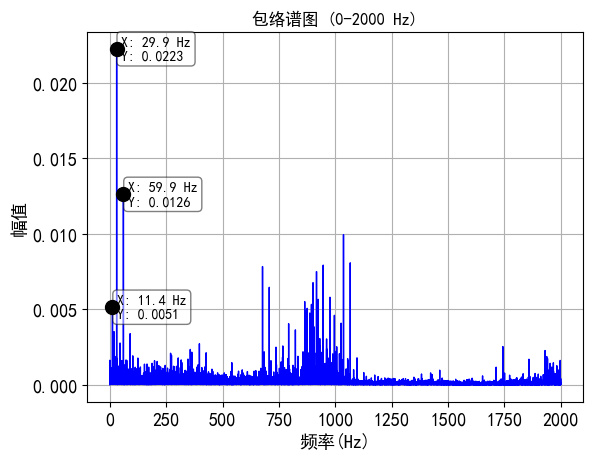

161.69546035541995
[161.69546036  59.8688822  323.39092071]
[0.19119697 0.08540129 0.05265164]


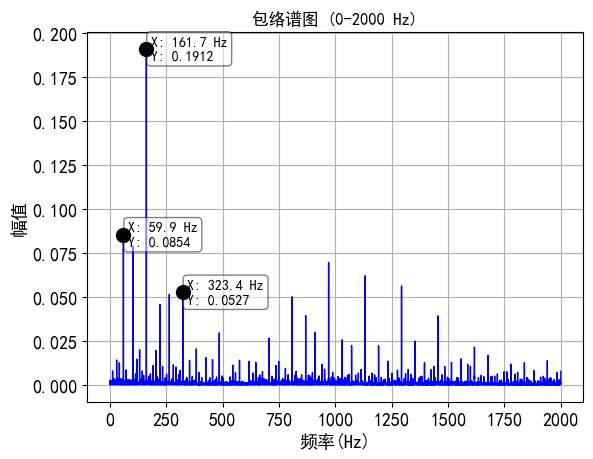

215.38536848030938
[215.38536848  29.95814671 430.77073696]
[0.01848833 0.01638937 0.00677219]


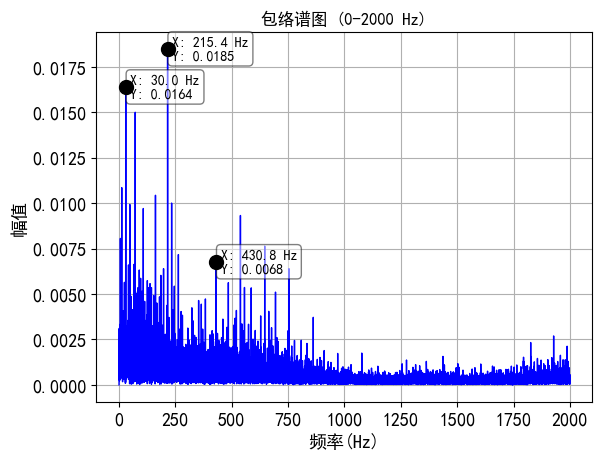

107.61449615135543
[107.61449615  29.90384537 215.32736022]
[0.56110394 0.12610194 0.30742284]


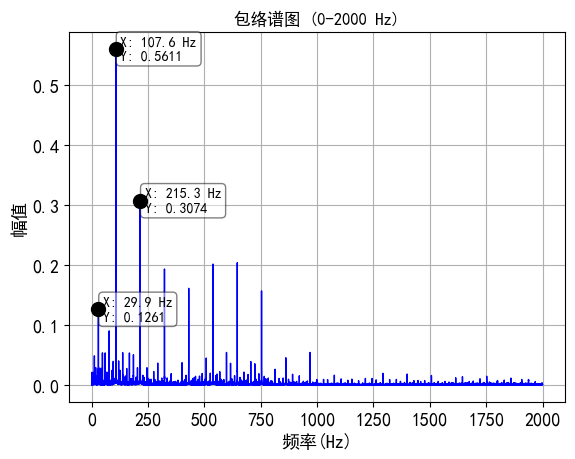

162.00778031285392
[162.00778031  29.93943174 324.01556063]
[0.08974851 0.08528796 0.03136368]


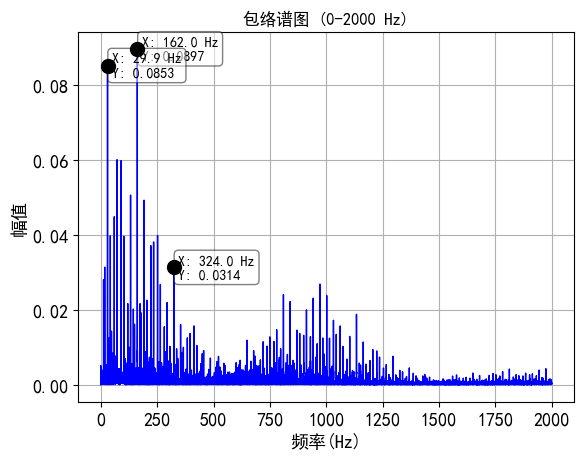

29.939431741706745
[29.93943174  0.09848497 52.68946047]
[0.01552345 0.04077208 0.00906246]


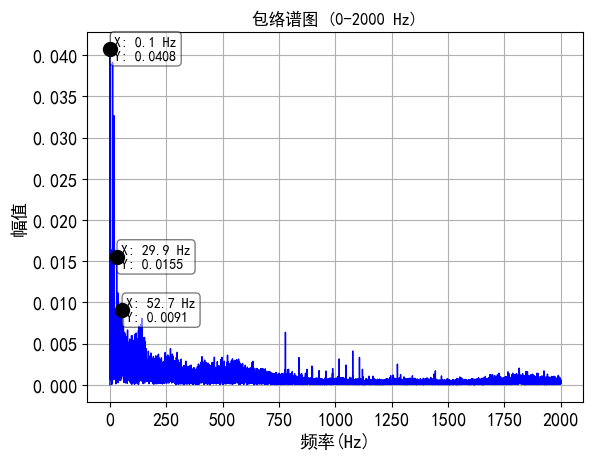

322.5382860331894
[322.53828603 179.14416559 725.24333995]
[0.00861405 0.00823574 0.00616164]


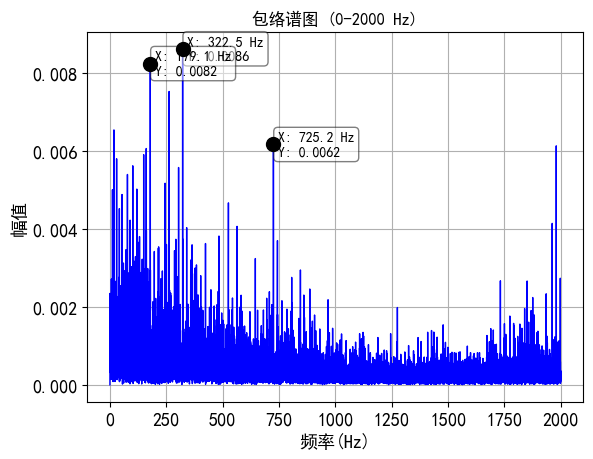

29.966594615838083
[29.96659462 12.18314011 72.01807821]
[0.26285627 0.02865558 0.10134769]


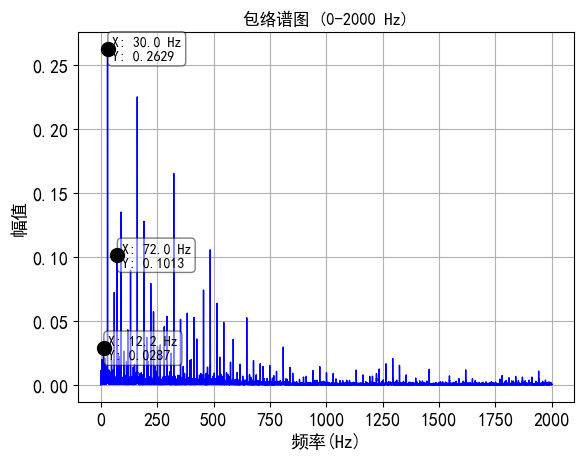

161.91358378896803
[161.91358379   1.18041495 323.82716758]
[0.02484692 0.02271104 0.01129466]


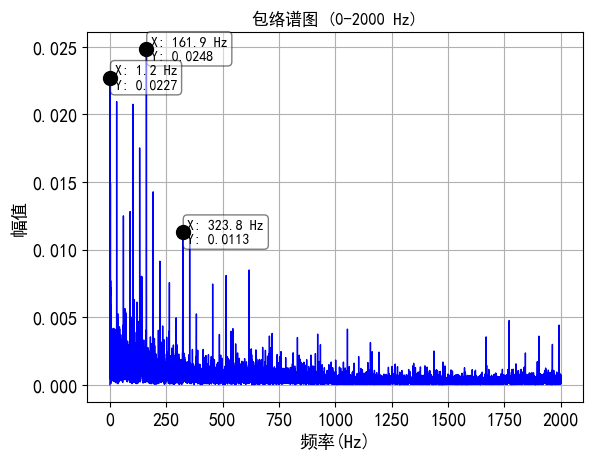

107.52617907960727
[107.52617908  29.89561041 215.05235816]
[0.38851267 0.33565294 0.13978347]


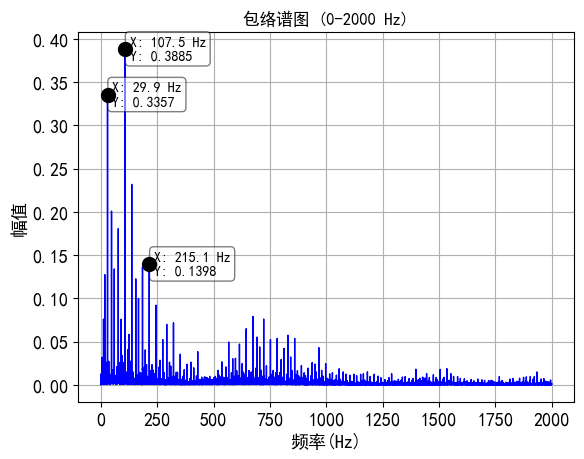

29.460449718228652
[29.46044972 14.75502322 58.89610108]
[0.01174781 0.0057482  0.00686839]


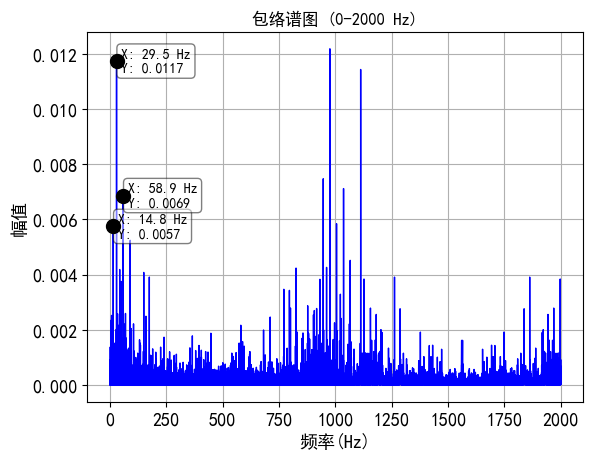

28.994171891073943
[28.99417189 14.57130311 57.98834378]
[0.01028622 0.00504384 0.00531567]


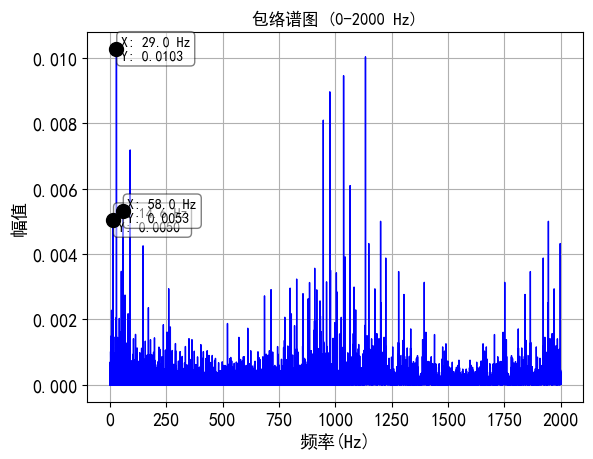

159.55275389168054
[159.55275389 100.43363855 319.10550778]
[0.19014076 0.06644177 0.05047882]


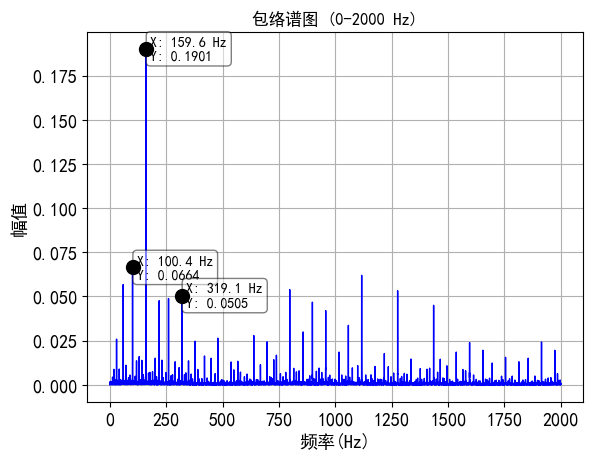

157.39831008056592
[157.39831008  58.26292002 314.79662016]
[0.18654513 0.08790674 0.05131309]


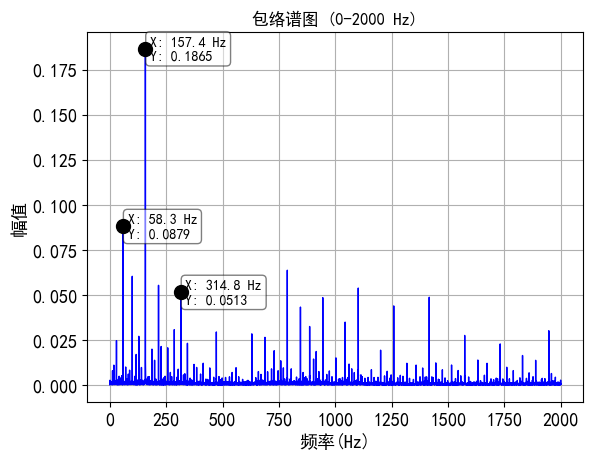

159.4267358537188
[159.42673585  59.00667161 277.53891772]
[0.01552489 0.013341   0.00639801]


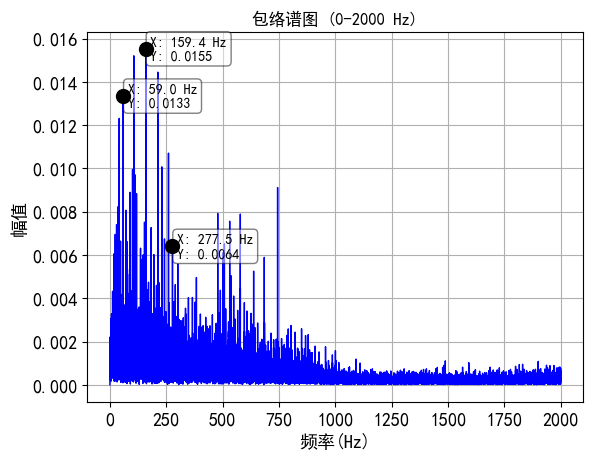

75.81690743361085
[ 75.81690743  40.77133173 157.3595709 ]
[0.01978875 0.0178959  0.01718697]


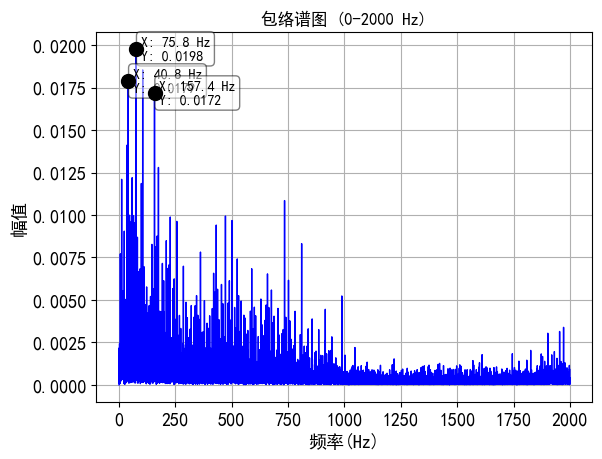

106.25193994739679
[106.25193995  29.50353683 212.60189829]
[0.37384106 0.10207757 0.35146754]


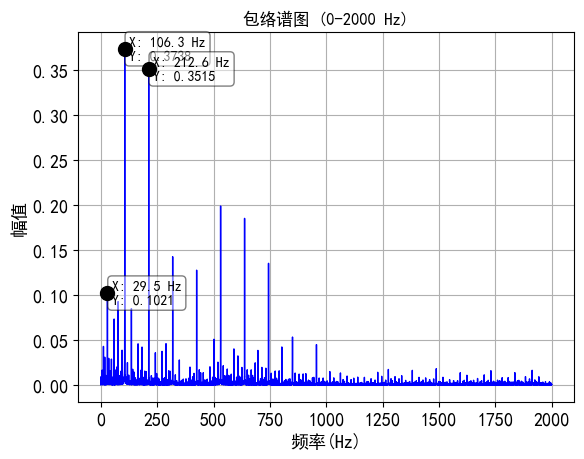

104.9666419570052
[104.96664196  29.15740054 209.83444527]
[0.3586019  0.12284985 0.33308533]


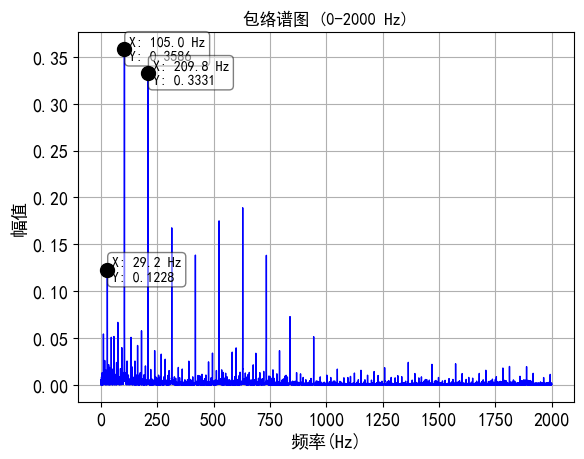

160.0380808561627
[160.03808086  88.63647555 319.97767674]
[0.06485232 0.06101161 0.0306789 ]


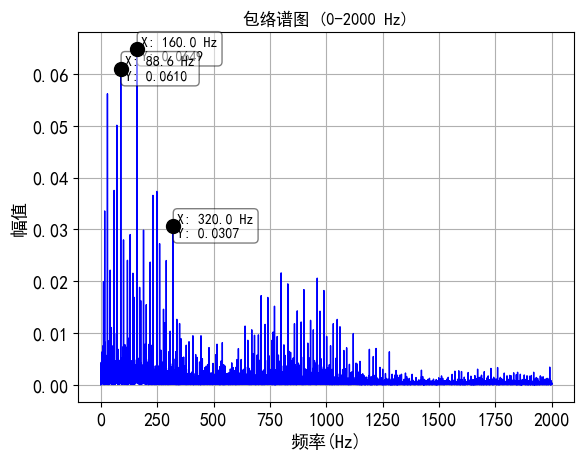

87.55314084992531
[ 87.55314085  29.15155196 158.0683814 ]
[0.05873854 0.04860516 0.0520386 ]


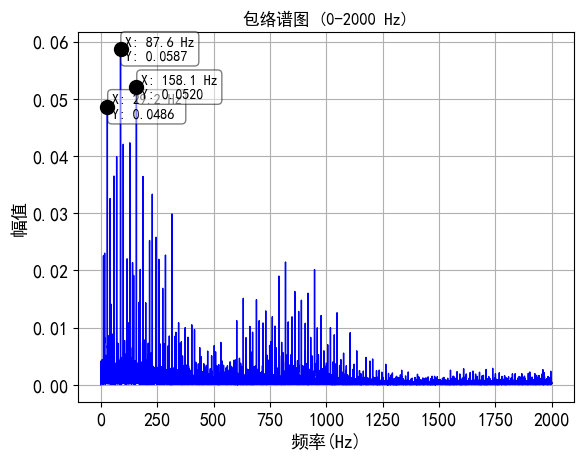

11.691884456671252
[11.69188446  2.9475339  21.61524858]
[0.02912191 0.01358135 0.00677784]


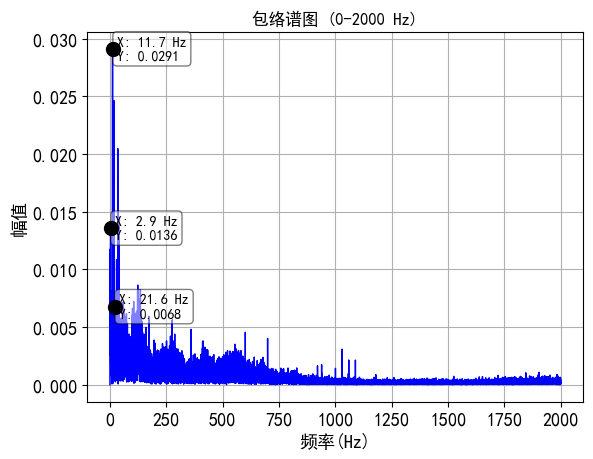

11.607413661663566
[11.60741366  0.19673582 23.8050348 ]
[0.03864067 0.02424448 0.00720944]


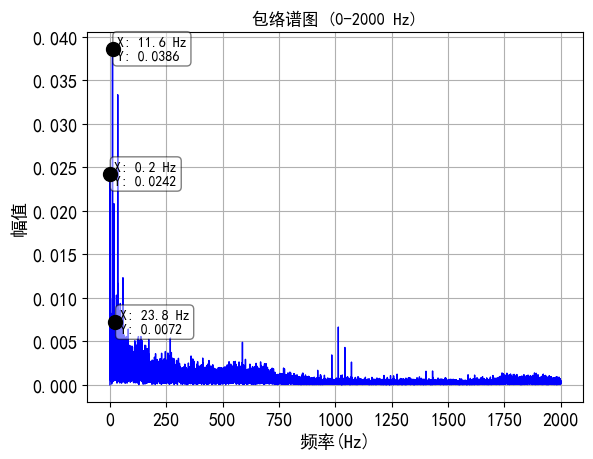

17.685203379838867
[17.68520338 11.29887994 41.36372568]
[0.01042504 0.00483725 0.0098786 ]


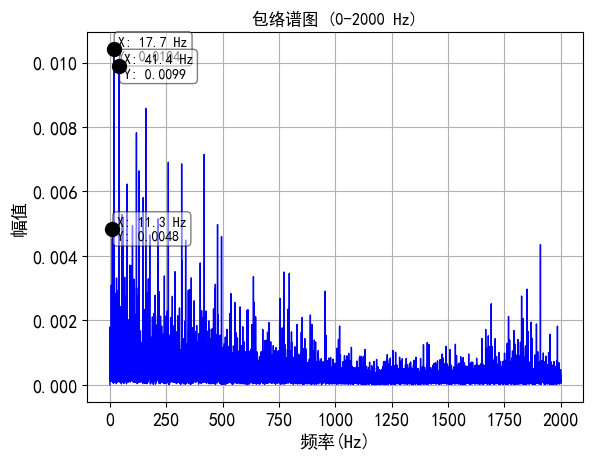

17.431840191717413
[17.43184019  5.90909837 40.87126373]
[0.01014666 0.00441834 0.00938585]


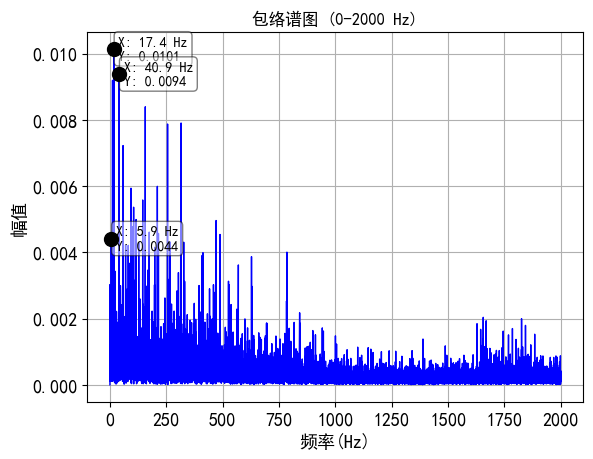

159.8275691862187
[159.82756919  88.65049854 319.55641844]
[0.22005039 0.13772885 0.13673229]


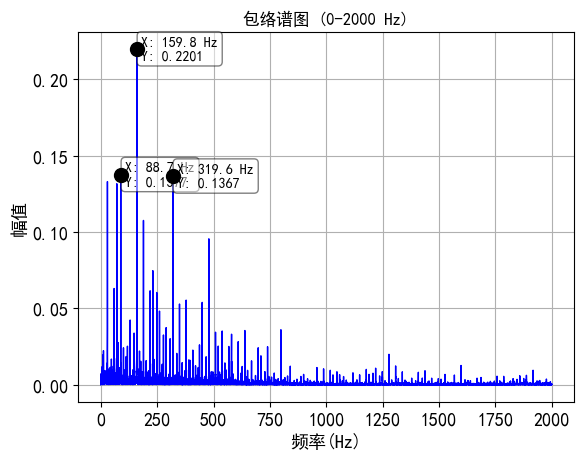

157.77292648096778
[157.77292648  70.21978563 315.64433793]
[0.28557678 0.1663181  0.13211232]


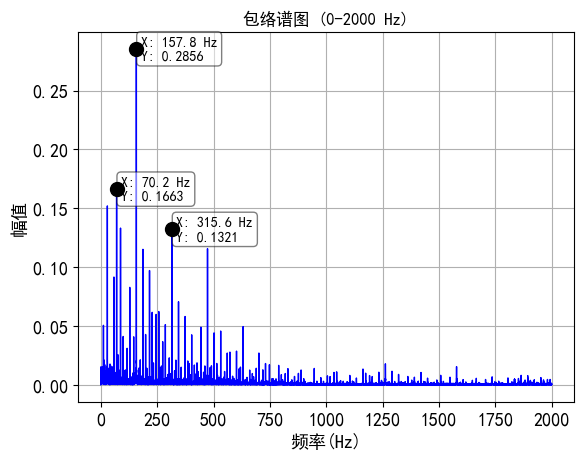

1.18322774669066
[1.18322775 0.09860231 2.07064856]
[0.02356043 0.01391048 0.01406653]


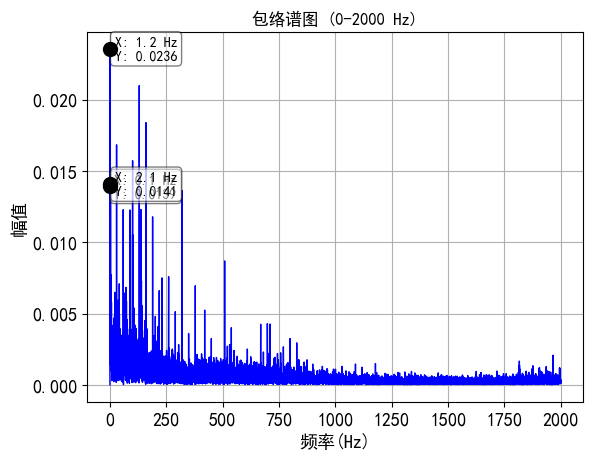

99.52839457653764
[ 99.52839458  29.18058558 187.07015131]
[0.01967774 0.01728693 0.01221612]


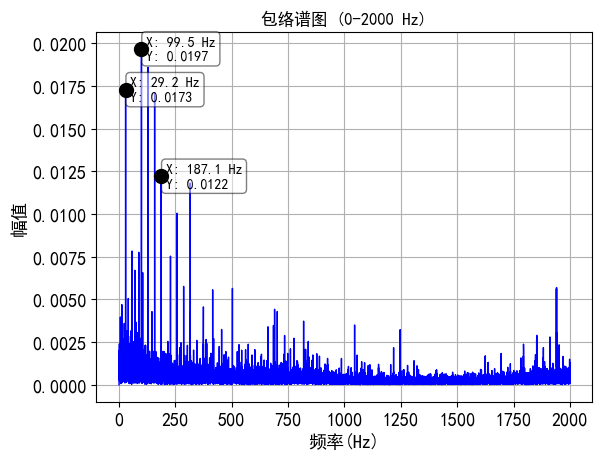

106.04060955316376
[106.04060955  29.51037372 212.08121911]
[0.40762932 0.36353676 0.19233679]


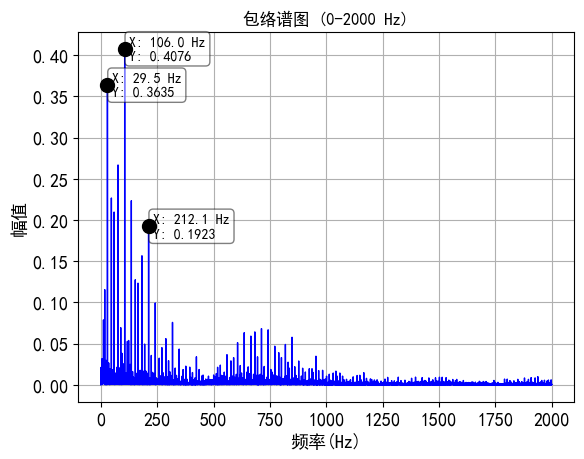

104.61150955585904
[104.61150956  29.14598343 209.22301911]
[0.40385942 0.31551712 0.1984327 ]


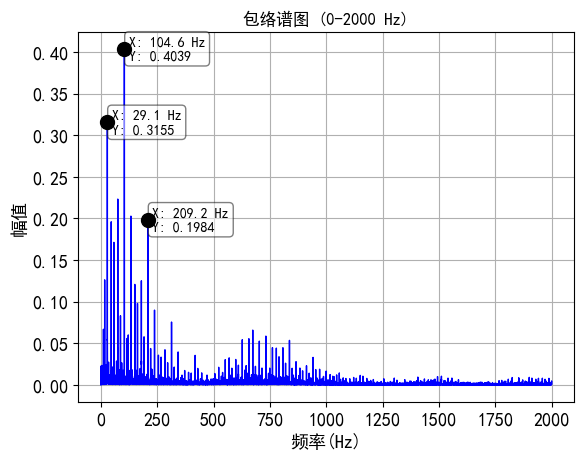

处理后样本shape： (30, 1, 3)
处理后数据类别分布： Counter({0: 3, 1: 3, 2: 3, 3: 3, 4: 3, 5: 3, 6: 3, 7: 3, 8: 3, 9: 3})


In [201]:

data_list=[]
label_list=[]
for filename in file_names.keys():
    data,label=data_load(file_names,filename)
    data_list.append(data)
    label_list.append(label)

datalist=[]
for i in range (len(data_list)):
    datalist+=data_list[i]
labelist=[]
for i in range (len(label_list)):
    labelist+=label_list[i]

data_train=np.asarray(datalist,dtype='float64')

label=np.asarray(labelist,dtype='int64')
print("处理后样本shape：",data_train.shape)
print("处理后数据类别分布：",Counter(label))

# 4. 数据处理与收集(样本间隔 12000)

In [70]:
def data_load(file_names, filename):  
    if int(filename) > 100:  
        data = loadmat(f'data/12k Drive End Bearing Fault Data/{filename}.mat')  
    elif int(filename) < 100:  
        data = loadmat(f'data/Normal Baseline Data/{filename[1:]}.mat')  
    X_DE_time = data[f'X{filename}_DE_time'].flatten()  

    # 采样频率  
    fs = 2000
    t = np.arange(len(X_DE_time)) / fs  

    # 初始化用于存储结果的数组  
    all_list_DE = []  
    all_label_DE = []  

    # 循环处理每12000条数据  
    for i in range(0, len(X_DE_time), fs):  
        X_DE_time_chunk = X_DE_time[i:i+fs]  

        # 包络谱分析  
        analytic_signal = hilbert(X_DE_time_chunk)  
        envelope = np.abs(analytic_signal)  

        # 对包络进行FFT  
        N = len(envelope)  
        envelope_fft = fft(envelope, N)  
        envelope_magnitude = np.abs(envelope_fft) / (N / 2)  
        envelope_magnitude[0] = 0  

        # 频率值(仅正频率)  
        f = np.arange(N) * fs / N  
        positive_freq_mask = f >= 0  
        freq_mask = (f <= 2000) & positive_freq_mask  

        # 提取正频率范围内的频率和幅值  
        frequencies = f[freq_mask]  
        magnitudes = envelope_magnitude[freq_mask]  

        if frequencies[np.argmax(magnitudes)] < 1 or frequencies[np.argmax(magnitudes)] > 900:  
            freq_mask2 = (frequencies > 28) & (frequencies < 900)  
        else:  
            freq_mask2 = (frequencies > 0) & (frequencies < 2000)  

        # 找到前两个最高峰  
        if len(magnitudes) > 0:  
            peak_values = np.max(magnitudes[freq_mask2])  
            peak_indices = np.argmax(magnitudes[freq_mask2])  
            peak_freqs = frequencies[freq_mask2][peak_indices]  

            # 确定第一个峰值频率  
            first_peak_index = peak_indices  
            first_peak_freq = peak_freqs  

            # 确定'半频'和'双频'  
            start_freq = first_peak_freq.astype(int)  
            left_mask = (frequencies > 0) & (frequencies < start_freq /1.5)  
            if np.any(left_mask):  
                half_freq_value = np.max(magnitudes[left_mask])  
                half_freq_index = np.argmax(magnitudes[left_mask])  
                half_freq = frequencies[left_mask][half_freq_index]  
            else:  
                half_freq_value = peak_values*0
                half_freq = None  

            right_mask = (frequencies > start_freq*1.7) & (frequencies <= start_freq*2.5)  
            if np.any(right_mask):  
                double_freq_value = np.max(magnitudes[right_mask])  
                double_freq_index = np.argmax(magnitudes[right_mask])  
                double_freq = frequencies[right_mask][double_freq_index]  
            else:  
                double_freq_value = None  
                double_freq = None  
                print(double_freq_value)

            # 将本次结果添加到list_DE和label_DE中  
            list_DE = [peak_values, half_freq_value, double_freq_value]  
            label_DE = file_names[filename]  

            all_list_DE.append([list_DE])  
            all_label_DE.append(label_DE)  
        else:  
            list_DE = []  
            label_DE = file_names[filename]  
            all_list_DE.append(list_DE)  
            all_label_DE.append(label_DE)  

    return all_list_DE[:60], all_label_DE[:60]  

In [71]:
file_names = {'097':0 ,'105':1, '118':2, '130':3, '169':4, '185':5, '197':6, '209':7, '222':8, '234':9,'098':0, '099':0,'106':1,'107':1,'119':2,'120':2,'131':3,'132':3,'170':4,'171':4,'186':5,'187':5,'198':6,'199':6,'210':7,'211':7,'223':8,'224':8,'235':9,'236':9}
data_list=[]
label_list=[]
for filename in file_names.keys():
    data,label=data_load(file_names,filename)
    
    data_list.append(data)
    label_list.append(label)

datalist=[]
for i in range (len(data_list)):
    datalist+=data_list[i]
labelist=[]
for i in range (len(label_list)):
    labelist+=label_list[i]

data_train=np.asarray(datalist,dtype='float64')

label=np.asarray(labelist,dtype='int64')
print("处理后样本shape：",data_train.shape)
print("处理后数据类别分布：",Counter(label))

处理后样本shape： (1800, 1, 3)
处理后数据类别分布： Counter({0: 180, 1: 180, 2: 180, 3: 180, 4: 180, 5: 180, 6: 180, 7: 180, 8: 180, 9: 180})


In [72]:
# 保存数据
np.save("train_data/train_data_FFT.npy",data_train)
np.save("train_data/label_FFT.npy",label)
print("数据保存成功，位置：/train_data/")

数据保存成功，位置：/train_data/
